# Analyse ERA5 demand for NEM

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from xhistogram.xarray import histogram

import pickle

import shap
#shap.initjs()

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [3]:
%load_ext autoreload
%autoreload 2

### Set global variables

In [4]:
RESULTS_PATH = "/g/data/w42/dr6273/work/projects/Aus_energy/model_results/"

In [5]:
MARKET = "NEM" # "NEM" or "EU"

In [6]:
REMOVE_WEEKEND = True

In [7]:
REMOVE_XMAS = True

In [8]:
REMOVE_MONTH = 0 # integer: [1, 12]

In [9]:
MASK_NAME = "pop_dens_mask"

In [10]:
FIRST_TRAIN_YEAR = 2010
LAST_TRAIN_YEAR = 2016

In [11]:
FIRST_TEST_YEAR = 1959
LAST_TEST_YEAR = 2022

In [12]:
N_FEATURES = "parsimonious"

In [13]:
# DETREND = True

In [14]:
regions = ["NEM", "QLD", "NSW", "VIC", "SA", "TAS"]

### Load model data

In [15]:
predictions = fn.read_results(
    "extrapolated", MARKET, regions, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH,
    detrended=True
)

Days to exclude

In [16]:
# to_exclude = fn.read_results(
#     "predictors_excluded", MARKET, regions, MASK_NAME,
#     FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
#     REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH,
#     detrended=True
# )

In [17]:
pred_ds = {}
for r in regions:
    ds = xr.Dataset.from_dataframe(predictions[r])
    ds = ds.rename({"index": "time", "prediction": "demand"})
    ds = ds.assign_coords({"time": pd.to_datetime(ds["time"])})
    
#     to_exc = xr.Dataset.from_dataframe(to_exclude[r])["0"]
#     to_exc = to_exc.rename({"index": "time"})
    
#     pred_ds[r] = ds.where(to_exc == 0)

    pred_ds[r] = ds

Note:
For features and hyperparameters, we set `detrended=False` because all models are trained on detrended data, so none of them have "_detrended" in the filename

In [18]:
# Population density mask, remove weekends and Xmas
features = fn.read_results(
    "feature_selection", MARKET, regions, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, 2017, 2019,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH,
    detrended=False
)

In [19]:
hyperparameters = fn.read_results(
    "hyperparameters", MARKET, regions, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, 2017, 2019,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH,
    detrended=False
)

### SHAP analysis

How do the predictors contribute to the predictions for the new training period (2010-2019) and the new test period (1959-2022)?

In [20]:
# write_SHAP = False

In [21]:
# dem_da = xr.open_dataset("/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_2010-2020_stl.nc")["demand_stl"]

In [22]:
# DETREND = True

# trainX_dict = {}
# testX_dict = {}

# shap_train = {}
# shap_test = {}

# explainer_train = {}
# explainer_test = {}

# for r in regions:
#     cal = fn.get_calendar(MARKET, r)
#     dem = fn.remove_time(dem_da, REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, cal).sel(region=r)
#     train_pred = fn.remove_time(pred_ds[r], REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, cal).drop(["demand", "is_workday"])
#     test_pred = pred_ds[r].drop(["demand"])
        
#     train_X = train_pred.sel(time=slice(str(FIRST_TRAIN_YEAR), str(LAST_TRAIN_YEAR))).to_dataframe().values
#     test_X = test_pred.to_dataframe().values
#     train_y = dem.loc[slice(str(FIRST_TRAIN_YEAR), str(LAST_TRAIN_YEAR))].values
    
#     # Remove rows with NaNs that we introduced earlier
#     test_X = test_X[~np.isnan(test_X).any(axis=1), :]
    
#     # And get dates that we keep
#     to_exc = xr.Dataset.from_dataframe(to_exclude[r])["0"]
#     to_exc = to_exc.rename({"index": "time"})
#     index_keep = test_pred[list(test_pred.data_vars)[0]].where(to_exc == 0).dropna("time").time
    
#     trainX_dict[r] = train_X
#     testX_dict[r] = test_X
    
#     filename_train = fn.get_filename(
#         "SHAP_train", MARKET, r, MASK_NAME,
#         FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
#         REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES
#     )
#     if DETREND:
#         filename_train = filename_train + "_detrended"
        
#     filename_test = fn.get_filename(
#         "SHAP_test", MARKET, r, MASK_NAME,
#         FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
#         REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES
#     )
#     if DETREND:
#         filename_test = filename_test + "_detrended"
    
#     if write_SHAP:
#         from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
        
#         # Finalise model
#         rf = ExtraTreesRegressor(
#             n_estimators=int(hyperparameters[r].loc["n_estimators"].values),
#             min_samples_leaf=int(hyperparameters[r].loc["min_samples_leaf"].values),
#             max_depth=int(hyperparameters[r].loc["max_depth"].values),
#             max_leaf_nodes=int(hyperparameters[r].loc["max_leaf_nodes"].values),
#             random_state=0,
#         )

#         model_train, _ = fn.predict_forest(train_y, train_X, train_X, rf)
#         model_test, _ = fn.predict_forest(train_y, train_X, test_X, rf)

#         explainer = shap.Explainer(rf)
#         # explain_train = explainer.shap_values(train_X)
#         # explain_test = explainer.shap_values(test_X)
#         explain_train = explainer(train_X)
#         explain_test = explainer(test_X)
        
#         # Pickle entire explainer
#         with open(RESULTS_PATH + "/SHAP/random_forest/explainer_" + filename_train + ".pkl", "wb") as f:
#              pickle.dump(explain_train, f)

#         # Write SHAP values separately to csv
#         shap_train[r] = pd.DataFrame(
#             explain_train.values,
#             index=pd.to_datetime(train_pred.sel(time=slice(str(FIRST_TRAIN_YEAR), str(LAST_TRAIN_YEAR)))["time"].values),
#             columns=list(train_pred.data_vars)
#         )
#         shap_train[r].to_csv(
#             RESULTS_PATH + "/SHAP/random_forest/" + filename_train + ".csv",
#         )

#         # Now for test
#         with open(RESULTS_PATH + "/SHAP/random_forest/explainer_" + filename_test + ".pkl", "wb") as f:
#              pickle.dump(explain_test, f)

#         shap_test[r] = pd.DataFrame(
#             explain_test.values,
#             # index=pd.to_datetime(test_pred.sel(time=slice(str(FIRST_TEST_YEAR), str(LAST_TEST_YEAR)))["time"].values),
#             index=pd.to_datetime(index_keep),
#             columns=list(test_pred.data_vars)
#         )

#         shap_test[r].to_csv(
#             RESULTS_PATH + "/SHAP/random_forest/" + filename_test + ".csv",
#         )
        
#     else:
#         with open(RESULTS_PATH + "/SHAP/random_forest/explainer_" + filename_train + ".pkl", "rb") as f:
#              explainer_train[r] = pickle.load(f)
#         with open(RESULTS_PATH + "/SHAP/random_forest/explainer_" + filename_test + ".pkl", "rb") as f:
#              explainer_test[r] = pickle.load(f)

In [23]:
# def plot_shap(vals, features, feature_names, colorbar=True, fontsize=10):
#     """
#     Custom shap summary plot
#     """
#     pl = shap.summary_plot(
#         vals,
#         features,
#         feature_names=feature_names,
#         # order=order,
#         plot_type="dot",
#         cmap="viridis",
#         color_bar=colorbar,
#         show=False,
#         plot_size=None,
#         sort=False # Don't sort predictor order
#     )

#     ax = plt.gca()
#     for pos in ["top", "bottom", "left", "right"]:
#         ax.spines[pos].set_visible(True)

#     ax.axes.grid(visible=True)
#     ax.axvline(0, c="k")
#     ax.set_xlabel("SHAP value " + r"[GWh d$^{-1}$]", fontsize=fontsize)
    
#     ax.yaxis.label.set_size(fontsize)
#     ax.tick_params(axis='both', which='major', labelsize=fontsize, pad=0)
    
#     return ax

In [24]:
# fig = plt.figure(figsize=(7,4))

# for i, r in enumerate(regions):
    
#     # Ensure default predictor order is retained
#     order_features = fn.parse_features(fn.sel_model(features[r])["feature_names"])[::-1]
#     # col2num = {col: i for i, col in enumerate(order_features)}
#     # order = list(map(col2num.get, order_features))
    
#     fig.add_subplot(2, 3, i+1)
#     a = plot_shap(
#         explainer_test[r].values / 1000,
#         testX_dict[r],
#         order_features,
#         # order=order,
#         colorbar=False
#     )
#     a.set_title(r)
#     # a.text(0.8, 0.05, r, transform=a.transAxes)
    
#     if i in [0, 1, 2]:
#         a.set_xlabel("")

# plt.subplots_adjust(wspace=0.75, hspace=0.35)
    
# # Figure legend
# cmap = plt.get_cmap('viridis')
# cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=100)
# scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
# scalarMap.set_array([])

# cax = fig.add_axes([0.26, 0.0, 0.5, 0.04])
# cbar = fig.colorbar(scalarMap, cax=cax, ticks=[0, 100], orientation="horizontal")
# cbar.ax.set_xticklabels(["Low", "High"])
# cbar.ax.set_xlabel("Feature value")

### Compare statistics of train (2010-2016) vs test (1959-2022)

In [21]:
def get_hist(da):
    """
    Compute bins and histogram of da
    """
    dmin = da.min().values
    dmax = da.max().values
    
    bins = np.linspace(
        fn.rounddown(dmin, 10),
        fn.roundup(dmax, 10),
        60
    )
    return histogram(da, bins=[bins], density=True)

In [22]:
def plot_hist(ax, histograms, labels, xlabel, colors=["tab:blue", "tab:orange"]):
    """
    Plot histograms
    """
    linestyles = ["--", "-"]
    for hist, label, color, ls in zip(histograms, labels, colors, linestyles):
        hist.plot(ax=ax, color=color, label=label, ls=ls)
    ax.set_ylabel(r"Density [d GWh$^{-1}$]")
    ax.set_xlabel(xlabel)

In [23]:
first_vars = [predictions[r].columns[0] for r in regions]

In [24]:
first_vars

['t2max', 't2max', 't2max', 't2max', 't2max', 't2m']

In [25]:
# first_vars_units = ["[deg C]", "[deg C]", "[deg C]", "[deg C]", "[deg C]", r"[W m$^{-2}$]"]

In [26]:
first_vars_units = [r"[$^{\circ}$C]", r"[$^{\circ}$C]", r"[$^{\circ}$C]",
                    r"[$^{\circ}$C]", r"[$^{\circ}$C]", r"[$^{\circ}$C]"]

In [27]:
second_vars = [predictions[r].columns[1] for r in regions]
second_vars

['msdwswrf', 'msdwswrf', 'msdwswrf', 'msdwswrf', 'msdwswrf', 'w10']

In [28]:
# second_vars_units = [r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", "[deg C]"]

In [29]:
second_vars_units = [r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[ms$^{-1}$]"]

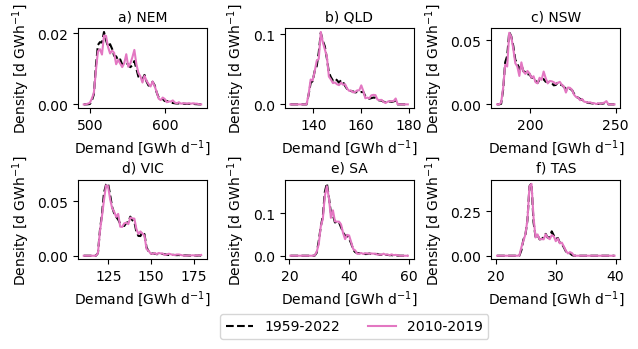

In [34]:
fig, ax = plt.subplots(2, 3, figsize=(7,3))

letters = ["a) ", "b) ", "c) ", "d) ", "e) ", "f) "]

for i, r in enumerate(regions):
    # Demand histograms
    hists = [
        get_hist(pred_ds[r]["demand"].sel(time=slice("1959", "2022")) / 1000),
        get_hist(pred_ds[r]["demand"].sel(time=slice("2010", "2019")) / 1000)
    ]
    plot_hist(ax.flatten()[i], hists, ["1959-2022", "2010-2019"],
              r"Demand [GWh d$^{-1}$]", colors=["k", "tab:pink"])     
    
    ax.flatten()[i].set_title(letters[i] + r, fontsize=10)
    
ax[1,1].legend(loc=(-0.5, -1), ncols=2)
plt.subplots_adjust(wspace=0.6, hspace=0.9)

plt.savefig("figures/demand_long_vs_short.pdf", format="pdf", bbox_inches="tight")

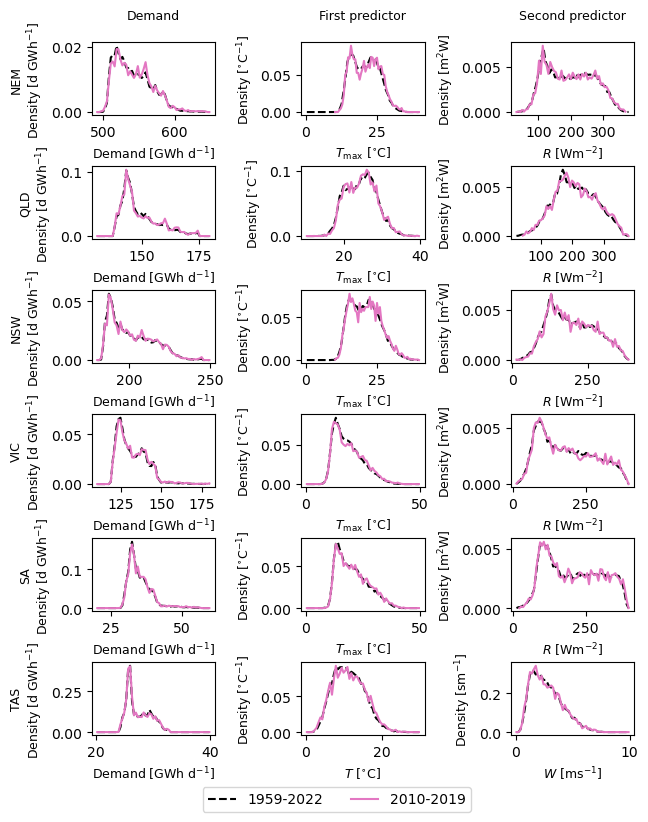

In [75]:
fig, ax = plt.subplots(6, 3, figsize=(7,9))

for i, r in enumerate(regions):
    # Demand histograms
    hists = [
        get_hist(pred_ds[r]["demand"].sel(time=slice("1959", "2022")) / 1000),
        get_hist(pred_ds[r]["demand"].sel(time=slice("2010", "2019")) / 1000)
    ]
    plot_hist(ax[i,0], hists, ["1959-2022", "2010-2019"],
              r"Demand [GWh d$^{-1}$]", colors=["k", "tab:pink"])   

    # Most important variable histograms
    if first_vars[i] in ["t2m", "t2m3", "t2m4", "t2max", "t2min", "cdd", "cdd3", "cdd4", "hdd", "hdd3", "hdd4"]:
        offset = -273.14
    else:
        offset = 0
        
    hists = [
        get_hist(pred_ds[r][predictions[r].columns[0]].sel(time=slice("1959", "2022")) + offset),
        get_hist(pred_ds[r][predictions[r].columns[0]].sel(time=slice("2010", "2019")) + offset)
    ]
    plot_hist(ax[i,1], hists, ["1959-2022", "2010-2019"],
             first_vars[i] + " " + first_vars_units[i], colors=["k", "tab:pink"])  
    
    # Second most important variable histograms
    if second_vars[i] in ["t2m", "t2m3", "t2m4", "t2max", "t2min", "cdd", "cdd3", "cdd4", "hdd", "hdd3", "hdd4"]:
        offset = -273.14
    else:
        offset = 0
        
    hists = [
        get_hist(pred_ds[r][predictions[r].columns[1]].sel(time=slice("1959", "2022")) + offset),
        get_hist(pred_ds[r][predictions[r].columns[1]].sel(time=slice("2010", "2019")) + offset)
    ]
    plot_hist(ax[i,2], hists, ["1959-2022", "2010-2019"],
             second_vars[i] + " " + second_vars_units[i], colors=["k", "tab:pink"])  
    
    if i == 0:
        ax[i,0].set_title("Demand\n", fontsize=9)
        ax[i,1].set_title("First predictor\n", fontsize=9)
        ax[i,2].set_title("Second predictor\n", fontsize=9)
    else:
        ax[i,0].set_title("")
        ax[i,1].set_title("")
        ax[i,2].set_title("")
        
    ax[i,0].set_ylabel(r + "\n" + r"Density [d GWh$^{-1}$]", fontsize=9)
    ax[i,1].set_ylabel(r"Density [$^{\circ}$C$^{-1}$]", fontsize=9)
    if i < 5:
        ax[i,2].set_ylabel(r"Density [m$^{2}$W]", fontsize=9)
    else:
        ax[i,2].set_ylabel(r"Density [sm$^{-1}$]", fontsize=9)
        
    ax[i,0].set_xlabel(r"Demand [GWh d$^{-1}$]", fontsize=9)
    if i < 5:
        ax[i,1].set_xlabel(r"$T_{\mathrm{max}}$ [$^{\circ}$C]", fontsize=9)
    else:
        ax[i,1].set_xlabel(r"$T$ [$^{\circ}$C]", fontsize=9)
    if i < 5:
        ax[i,2].set_xlabel(r"$R$ [Wm$^{-2}$]", fontsize=9)
    else:
        ax[i,2].set_xlabel(r"$W$ [ms$^{-1}$]", fontsize=9)
        
    if i == 5:
        ax[i,0].legend(ncols=2, loc=(0.9, -1.05))
        
plt.subplots_adjust(wspace=0.7, hspace=0.7)

plt.savefig("figures/predictor_target_pdfs.pdf", format="pdf", bbox_inches="tight")

### Distributions during ENSO events

Load Nino3.4 HadISST

In [30]:
nino34_monthly= xr.open_zarr(
    "/g/data/w42/dr6273/work/data/hadisst/climate_modes/hadisst_nino34_1959-2022.zarr",
    consolidated=True
).nino34_detrended.compute()

In [31]:
nino34 = nino34_monthly.resample(time="1D").pad() # Set daily values as for each month

In [32]:
# Custom December 2022 series to concat
dec22 = xr.DataArray(
    np.repeat(nino34.values[-1], 30),
    dims=["time"],
    coords={"time": pd.date_range("2022-12-02", "2022-12-31")}
)

In [33]:
nino34 = xr.concat([nino34, dec22], dim="time")

In [34]:
# 3-month rolling mean
nino34 = nino34.rolling(time=3).mean()

In [35]:
# nino34_ond = nino34.isel(time=nino34.time.dt.month.isin([10, 11, 12]))

In [36]:
def sel_enso(demand, enso, enso_type, period):
    """
    Select demand data for El Nino or La Nina events.
    
    demand: demand array
    enso: enso index array
    enso_type: str, "EN" or "LN"
    period: slice
    """
    if enso_type == "EN":
        return demand.where(enso > 0.8).sel(time=period)
    elif enso_type == "LN":
        return demand.where(enso < -0.8).sel(time=period)
    else:
        raise ValueError("Incorrect enso_type")

### Change in probability between short and long records

In [37]:
def prob(da, q):
    """
    Empirical probability of da > q
    """
    return da.where(da > q).count() / len(da.time)

In [38]:
def prob_decadal_var(
    var="demand",
    q=0.997,
    enso_type=None,
    reference_period=slice("1959", "2022"),
    split_periods=[slice(str(i), str(i+9)) for i in range(1960, 2020, 10)]
):
    """
    Get change in likelihood of event for different periods relative to reference.
    Can condition on enso flavour.
    
    var: str, variable to analyse
    q: float, quantile of 2010-19 to set as extreme
    enso_type: str, None, "EN" or "LN"
    reference_period: slice
    split_periods: list of slices
    """
    results = {r: [] for r in regions}
    
    for r in regions:
        ds = pred_ds[r][var]
        
        # Threshold for reference period
        reference_thresh = ds.sel(time=reference_period).quantile(q).values
        
        # Thresholds for each split
        # split_threshs = [ds.sel(time=p).quantile(q).values for p in split_periods]
        
        # Subset data for El Nino or La Nina, or not
        if enso_type == "EN":
            split_data = [ds.where(nino34 > 0.8).sel(time=p).dropna("time") for p in split_periods]
            # Probability during El Nino over reference period
            enso_prob = prob(
                ds.where(nino34 > 0.8).sel(time=reference_period).dropna("time"),
                reference_thresh
            ) * 100
        elif enso_type == "LN":
            split_data = [ds.where(nino34 < -0.8).sel(time=p).dropna("time") for p in split_periods]
            # Probability during La Nina over reference period
            enso_prob = prob(
                ds.where(nino34 < -0.8).sel(time=reference_period).dropna("time"),
                reference_thresh
            ) * 100
        elif enso_type is None:
            split_data = [ds.sel(time=p).dropna("time") for p in split_periods]
            enso_prob = None
        else:
            raise ValueError("Incorrect enso_type")
            
        # Thresholds for each split
        split_threshs = [da.quantile(q).values for da in split_data]
            
        # Probabilities of exceeding the reference threshold for each split
        split_probs = [prob(s, reference_thresh).values * 100 for s in split_data]
        
        results[r] = {
            "ref_prob": (1 - q) * 100,
            "ref_thresh": reference_thresh,
            "split_probs": split_probs,
            "split_thresh": split_threshs,
            "enso_ref_prob": enso_prob
        }
        
    return results

In [39]:
probs_p99 = prob_decadal_var(q=0.99)

In [40]:
probs_p99_EN = prob_decadal_var(q=0.99, enso_type="EN")

In [41]:
probs_p99_LN = prob_decadal_var(q=0.99, enso_type="LN")

In [42]:
probs_p99_7 = prob_decadal_var()

In [43]:
probs_p99_7_EN = prob_decadal_var(enso_type="EN")

In [44]:
probs_p99_7_LN = prob_decadal_var(enso_type="LN")

In [45]:
def plot_decadal(
    ax,
    data_dict,
    ref_prob,
    # difference_from_enso_ref_prob=False,
    plot_enso_ref_prob=False,
    splits=["1960-69", "1970-79", "1980-89", "1990-99", "2000-09", "2010-19"],
    markers=["o", "x", "^", "v", "s", "*"],
    remove_zeros=False
):
    """
    Scatter plot decadal probabilities for each region
    """
    cmap = matplotlib.cm.get_cmap('viridis')
    colors = [cmap(i) for i in np.linspace(0, 0.95, len(splits))]
    
    for i, (split, marker) in enumerate(
        zip(splits, markers)
    ):
        y = [data_dict[r]["split_probs"][i] for r in regions]
        
        # if difference_from_enso_ref_prob:
        #     y = [i - data_dict[r]["enso_ref_prob"]
        
        if remove_zeros:
            y = [i if i != 0 else np.nan for i in y]

        ax.scatter(range(len(regions)), y, color=colors[i], marker=marker, label=split)
        
    if plot_enso_ref_prob:
        y2 = [data_dict[r]["enso_ref_prob"] for r in regions]
        ax.scatter(range(len(regions)), y2, marker="d", color="tab:pink", label="1959-2022")

    ax.axhline(ref_prob, c="k", lw=0.7)
    ax.set_xticks(range(len(regions)))
    ax.set_xticklabels(regions)
    ax.set_ylabel("Probability [%]")
    
    return ax

(0.0, 1.0, 0.0, 1.0)

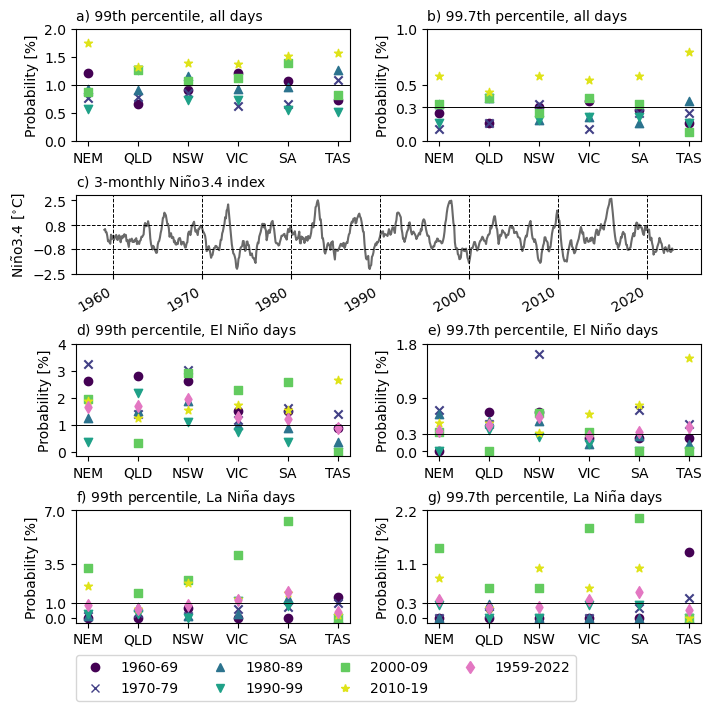

In [81]:
fig = plt.figure(figsize=(7, 7), constrained_layout=True)
gs = fig.add_gridspec(5, 2, height_ratios=[1, 0.7, 1., 1., 0.1])

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])
ax4 = fig.add_subplot(gs[2,0])
ax5 = fig.add_subplot(gs[2,1])
ax6 = fig.add_subplot(gs[3,0])
ax7 = fig.add_subplot(gs[3,1])
ax8 = fig.add_subplot(gs[4,:])
# axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

# All days
plot_decadal(ax1, probs_p99, ref_prob=1)
ax1.set_title("a) 99th percentile, all days", fontsize=10, loc="left")
ax1.set_yticks(np.arange(0, 2.01, 0.5))

plot_decadal(ax2, probs_p99_7, ref_prob=0.3)
ax2.set_title("b) 99.7th percentile, all days", fontsize=10, loc="left")
ax2.set_yticks([0, 0.3, 0.5, 1])

# Nino34
nino34_monthly.sel(time=slice("1959", "2022")).plot(ax=ax3, color="dimgray")
ax3.axhline(-0.8, c="k", lw=0.7, ls="--")
ax3.axhline(0.8, c="k", lw=0.7, ls="--")
ax3.set_yticks([-2.5, -0.8, 0.8, 2.5])
ax3.set_ylabel(r"Ni$\mathrm{\tilde{n}}$o3.4 [$^{\circ}$C]")
ax3.set_xlabel("")
ax3.set_title(r"c) 3-monthly Ni$\mathrm{\tilde{n}}$o3.4 index", fontsize=10, loc="left")
for d in range(1960, 2021, 10):
    ax3.axvline(pd.to_datetime(str(d) + "-01-01"), c="k", ls="--", lw=0.7)

# El Nino
plot_decadal(ax4, probs_p99_EN, plot_enso_ref_prob=True, ref_prob=1)
ax4.set_title(r"d) 99th percentile, El Ni$\mathrm{\tilde{n}}$o days", fontsize=10, loc="left")
ax4.set_yticks(range(5))

plot_decadal(ax5, probs_p99_7_EN, plot_enso_ref_prob=True, ref_prob=0.3)
ax5.set_title(r"e) 99.7th percentile, El Ni$\mathrm{\tilde{n}}$o days", fontsize=10, loc="left")
ax5.set_yticks([0, 0.3, 0.9, 1.8])

# La Nina
plot_decadal(ax6, probs_p99_LN, plot_enso_ref_prob=True, ref_prob=1)
ax6.set_title(r"f) 99th percentile, La Ni$\mathrm{\tilde{n}}$a days", fontsize=10, loc="left")
ax6.set_yticks([0, 1, 3.5, 7])

plot_decadal(ax7, probs_p99_7_LN, plot_enso_ref_prob=True, ref_prob=0.3)
p = ax7.set_title(r"g) 99.7th percentile, La Ni$\mathrm{\tilde{n}}$a days", fontsize=10, loc="left")
ax7.set_yticks([0, 0.3, 1.1, 2.2])

# Manual legend   
# col1 = Line2D([0], [0], marker='o', markeredgecolor="tab:blue", markerfacecolor="tab:blue", linestyle="")
# col2 = Line2D([0], [0], marker='x', markeredgecolor="tab:orange", markerfacecolor="tab:orange", linestyle="")
# col3 = Line2D([0], [0], marker='^', markeredgecolor="tab:green", markerfacecolor="tab:green", linestyle="")
# col4 = Line2D([0], [0], marker='v', markeredgecolor="tab:red", markerfacecolor="tab:red", linestyle="")
# col5 = Line2D([0], [0], marker='s', markeredgecolor="tab:purple", markerfacecolor="tab:purple", linestyle="")
# col6 = Line2D([0], [0], marker='*', markeredgecolor="tab:brown", markerfacecolor="tab:brown", linestyle="")
# col7 = Line2D([0], [0], marker='d', markeredgecolor="k", markerfacecolor="k", linestyle="")

cmap = matplotlib.cm.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 0.95, 6)]
items = []
for i, marker in enumerate(["o", "x", "^", "v", "s", "*"]):
    color = colors[i]
    line = Line2D([0], [0], marker=marker, markeredgecolor=color, markerfacecolor=color, linestyle="")
    items.append(line)
items.append(Line2D([0], [0], marker='d', markeredgecolor="tab:pink", markerfacecolor="tab:pink", linestyle=""))

ax8.legend(
    # [col1, col2, col3, col4, col5, col6, col7],
    items,
    ["1960-69", "1970-79", "1980-89", "1990-99", "2000-09", "2010-19", "1959-2022"],
    loc=(0, 0),
    ncol=4,
    frameon=True
)
ax8.axis("off")

plt.savefig("figures/conditional_probabilities.pdf", format="pdf", bbox_inches="tight")

### Repeat but for t2m

To assess if big changes in probability are only demand, or also occur in predictors

In [46]:
# Want cold extremes too so use absolute anomalies
for r in pred_ds.keys():
    pred_ds[r]["abs_t2m_anom"] = np.abs(pred_ds[r]["t2m"] - pred_ds[r]["t2m"].mean("time"))

In [47]:
t2m_probs_p99 = prob_decadal_var("abs_t2m_anom", q=0.99)

In [48]:
t2m_probs_p99_EN = prob_decadal_var("abs_t2m_anom", q=0.99, enso_type="EN")

In [49]:
t2m_probs_p99_LN = prob_decadal_var("abs_t2m_anom", q=0.99, enso_type="LN")

In [50]:
t2m_probs_p99_7 = prob_decadal_var("abs_t2m_anom", )

In [51]:
t2m_probs_p99_7_EN = prob_decadal_var("abs_t2m_anom", enso_type="EN")

In [52]:
t2m_probs_p99_7_LN = prob_decadal_var("abs_t2m_anom", enso_type="LN")

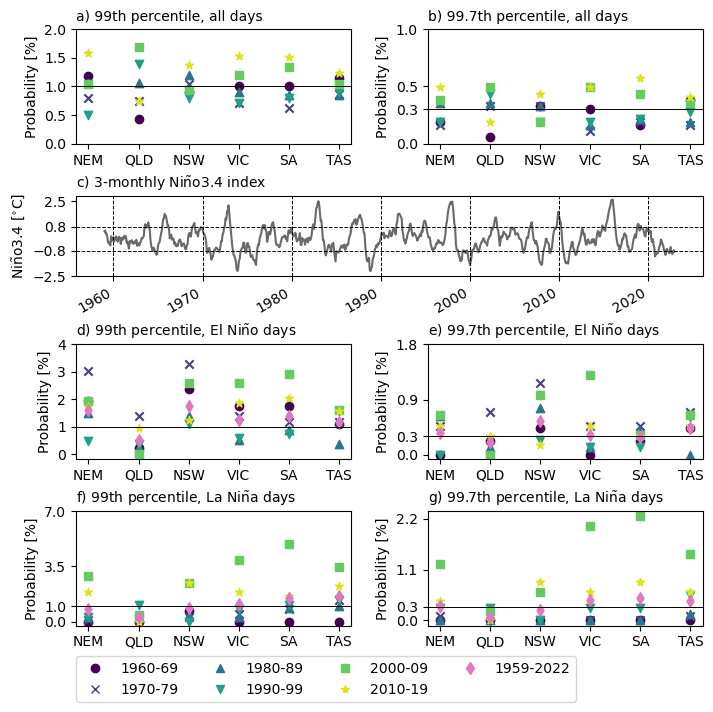

In [134]:
fig = plt.figure(figsize=(7, 7), constrained_layout=True)
gs = fig.add_gridspec(5, 2, height_ratios=[1, 0.7, 1., 1., 0.1])

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])
ax4 = fig.add_subplot(gs[2,0])
ax5 = fig.add_subplot(gs[2,1])
ax6 = fig.add_subplot(gs[3,0])
ax7 = fig.add_subplot(gs[3,1])
ax8 = fig.add_subplot(gs[4,:])
# axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

# All days
plot_decadal(ax1, t2m_probs_p99, ref_prob=1)
ax1.set_title("a) 99th percentile, all days", fontsize=10, loc="left")
ax1.set_yticks(np.arange(0, 2.01, 0.5))

plot_decadal(ax2, t2m_probs_p99_7, ref_prob=0.3)
ax2.set_title("b) 99.7th percentile, all days", fontsize=10, loc="left")
ax2.set_yticks([0, 0.3, 0.5, 1])

# Nino34
nino34_monthly.sel(time=slice("1959", "2022")).plot(ax=ax3, color="dimgray")
ax3.axhline(-0.8, c="k", lw=0.7, ls="--")
ax3.axhline(0.8, c="k", lw=0.7, ls="--")
ax3.set_yticks([-2.5, -0.8, 0.8, 2.5])
ax3.set_ylabel(r"Ni$\mathrm{\tilde{n}}$o3.4 [$^{\circ}$C]")
ax3.set_xlabel("")
ax3.set_title(r"c) 3-monthly Ni$\mathrm{\tilde{n}}$o3.4 index", fontsize=10, loc="left")
for d in range(1960, 2021, 10):
    ax3.axvline(pd.to_datetime(str(d) + "-01-01"), c="k", ls="--", lw=0.7)

# El Nino
plot_decadal(ax4, t2m_probs_p99_EN, plot_enso_ref_prob=True, ref_prob=1)
ax4.set_title(r"d) 99th percentile, El Ni$\mathrm{\tilde{n}}$o days", fontsize=10, loc="left")
ax4.set_yticks(range(5))

plot_decadal(ax5, t2m_probs_p99_7_EN, plot_enso_ref_prob=True, ref_prob=0.3)
ax5.set_title(r"e) 99.7th percentile, El Ni$\mathrm{\tilde{n}}$o days", fontsize=10, loc="left")
ax5.set_yticks([0, 0.3, 0.9, 1.8])

# La Nina
plot_decadal(ax6, t2m_probs_p99_LN, plot_enso_ref_prob=True, ref_prob=1)
ax6.set_title(r"f) 99th percentile, La Ni$\mathrm{\tilde{n}}$a days", fontsize=10, loc="left")
ax6.set_yticks([0, 1, 3.5, 7])

plot_decadal(ax7, t2m_probs_p99_7_LN, plot_enso_ref_prob=True, ref_prob=0.3)
p = ax7.set_title(r"g) 99.7th percentile, La Ni$\mathrm{\tilde{n}}$a days", fontsize=10, loc="left")
ax7.set_yticks([0, 0.3, 1.1, 2.2])

# Manual legend   
# col1 = Line2D([0], [0], marker='o', markeredgecolor="tab:blue", markerfacecolor="tab:blue", linestyle="")
# col2 = Line2D([0], [0], marker='x', markeredgecolor="tab:orange", markerfacecolor="tab:orange", linestyle="")
# col3 = Line2D([0], [0], marker='^', markeredgecolor="tab:green", markerfacecolor="tab:green", linestyle="")
# col4 = Line2D([0], [0], marker='v', markeredgecolor="tab:red", markerfacecolor="tab:red", linestyle="")
# col5 = Line2D([0], [0], marker='s', markeredgecolor="tab:purple", markerfacecolor="tab:purple", linestyle="")
# col6 = Line2D([0], [0], marker='*', markeredgecolor="tab:brown", markerfacecolor="tab:brown", linestyle="")
# col7 = Line2D([0], [0], marker='d', markeredgecolor="k", markerfacecolor="k", linestyle="")

cmap = matplotlib.cm.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 0.95, 6)]
items = []
for i, marker in enumerate(["o", "x", "^", "v", "s", "*"]):
    color = colors[i]
    line = Line2D([0], [0], marker=marker, markeredgecolor=color, markerfacecolor=color, linestyle="")
    items.append(line)
items.append(Line2D([0], [0], marker='d', markeredgecolor="tab:pink", markerfacecolor="tab:pink", linestyle=""))

ax8.legend(
    # [col1, col2, col3, col4, col5, col6, col7],
    items,
    ["1960-69", "1970-79", "1980-89", "1990-99", "2000-09", "2010-19", "1959-2022"],
    loc=(0, 0),
    ncol=4,
    frameon=True
)
ax8.axis("off")

plt.savefig("figures/conditional_probabilities_t2m.pdf", format="pdf", bbox_inches="tight")

### Scatter probabilities

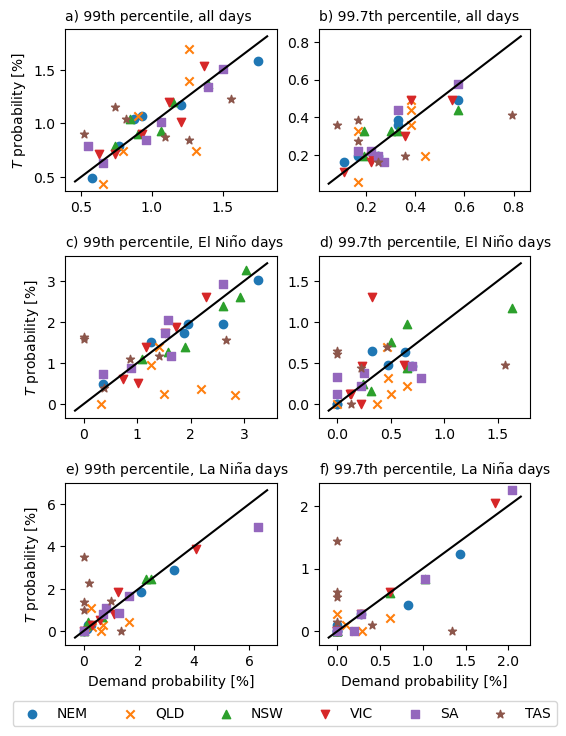

In [53]:
fig, ax = plt.subplots(3, 2, figsize=(6, 8))

markers=["o", "x", "^", "v", "s", "*"]

for i, r in enumerate(regions):
    ax[0,0].scatter(
        probs_p99[r]["split_probs"],
        t2m_probs_p99[r]["split_probs"],
        marker=markers[i],
        label=r
    )
    ax[0,1].scatter(
        probs_p99_7[r]["split_probs"],
        t2m_probs_p99_7[r]["split_probs"],
        marker=markers[i]
    )
    
    ax[1,0].scatter(
        probs_p99_EN[r]["split_probs"],
        t2m_probs_p99_EN[r]["split_probs"],
        marker=markers[i]
    )
    ax[1,1].scatter(
        probs_p99_7_EN[r]["split_probs"],
        t2m_probs_p99_7_EN[r]["split_probs"],
        marker=markers[i]
    )
    
    ax[2,0].scatter(
        probs_p99_LN[r]["split_probs"],
        t2m_probs_p99_LN[r]["split_probs"],
        label=r,
        marker=markers[i]
    )
    ax[2,1].scatter(
        probs_p99_7_LN[r]["split_probs"],
        t2m_probs_p99_7_LN[r]["split_probs"],
        marker=markers[i]
    )
    
for a in ax.flatten():
    a.plot(
        (a.get_xlim()[0], a.get_xlim()[1]), (a.get_xlim()[0], a.get_xlim()[1]),
        c="k"
    )
    
ax[2,0].legend(ncol=6, loc=(-0.25, -0.5))

for i in range(2):
    ax[2,i].set_xlabel("Demand probability [%]")
    
for i in range(3):
    ax[i,0].set_ylabel(r"$T$ probability [%]")

ax[0,0].set_title("a) 99th percentile, all days", fontsize=10, loc="left")
ax[0,1].set_title("b) 99.7th percentile, all days", fontsize=10, loc="left")
ax[1,0].set_title(r"c) 99th percentile, El Ni$\mathrm{\tilde{n}}$o days", fontsize=10, loc="left")
ax[1,1].set_title(r"d) 99.7th percentile, El Ni$\mathrm{\tilde{n}}$o days", fontsize=10, loc="left")
ax[2,0].set_title(r"e) 99th percentile, La Ni$\mathrm{\tilde{n}}$a days", fontsize=10, loc="left")
ax[2,1].set_title(r"f) 99.7th percentile, La Ni$\mathrm{\tilde{n}}$a days", fontsize=10, loc="left")

plt.subplots_adjust(hspace=0.4)

plt.savefig("figures/conditional_probabilities_demand_vs_t2m.pdf", format="pdf", bbox_inches="tight")

#### Difference in probabilities

In [135]:
diff_probs_p99 = {}
diff_probs_p99_7 = {}
diff_probs_p99_EN = {}
diff_probs_p99_7_EN = {}
diff_probs_p99_LN = {}
diff_probs_p99_7_LN = {}

for r in regions:
    diff_probs_p99[r] = {}
    diff_probs_p99_7[r] = {}
    
    diff_probs_p99_EN[r] = {}
    diff_probs_p99_7_EN[r] = {}
    
    diff_probs_p99_LN[r] = {}
    diff_probs_p99_7_LN[r] = {}
    
    diff_probs_p99[r]["split_probs"] = np.array(probs_p99[r]["split_probs"]) - np.array(t2m_probs_p99[r]["split_probs"])
    diff_probs_p99_7[r]["split_probs"] = np.array(probs_p99_7[r]["split_probs"]) - np.array(t2m_probs_p99_7[r]["split_probs"])
    
    diff_probs_p99_EN[r]["split_probs"] = np.array(probs_p99_EN[r]["split_probs"]) - np.array(t2m_probs_p99_EN[r]["split_probs"])
    diff_probs_p99_7_EN[r]["split_probs"] = np.array(probs_p99_7_EN[r]["split_probs"]) - np.array(t2m_probs_p99_7_EN[r]["split_probs"])
    diff_probs_p99_EN[r]["enso_ref_prob"] = probs_p99_EN[r]["enso_ref_prob"] - t2m_probs_p99_EN[r]["enso_ref_prob"]
    diff_probs_p99_7_EN[r]["enso_ref_prob"] = probs_p99_7_EN[r]["enso_ref_prob"] - t2m_probs_p99_7_EN[r]["enso_ref_prob"]
    
    diff_probs_p99_LN[r]["split_probs"] = np.array(probs_p99_LN[r]["split_probs"]) - np.array(t2m_probs_p99_LN[r]["split_probs"])
    diff_probs_p99_7_LN[r]["split_probs"] = np.array(probs_p99_7_LN[r]["split_probs"]) - np.array(t2m_probs_p99_7_LN[r]["split_probs"])
    diff_probs_p99_LN[r]["enso_ref_prob"] = probs_p99_LN[r]["enso_ref_prob"] - t2m_probs_p99_LN[r]["enso_ref_prob"]
    diff_probs_p99_7_LN[r]["enso_ref_prob"] = probs_p99_7_LN[r]["enso_ref_prob"] - t2m_probs_p99_7_LN[r]["enso_ref_prob"]
    

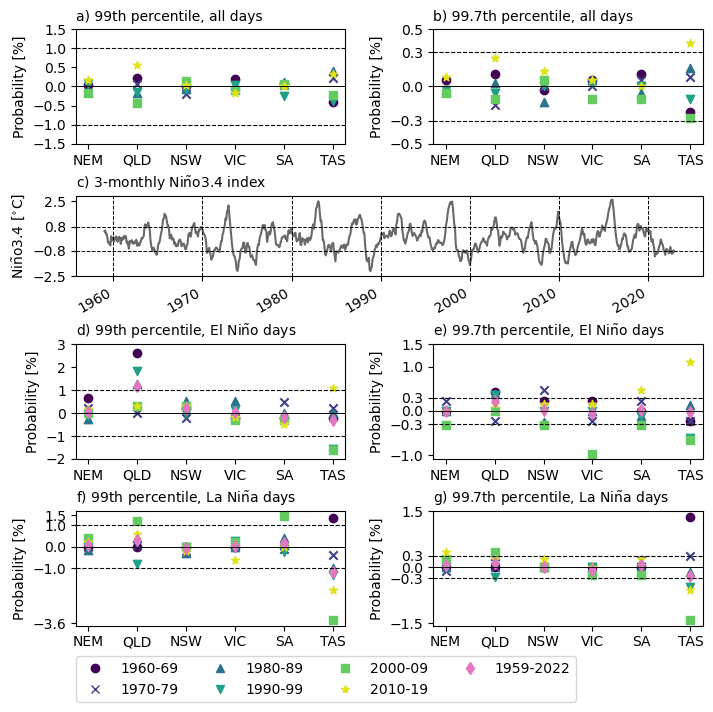

In [142]:
fig = plt.figure(figsize=(7, 7), constrained_layout=True)
gs = fig.add_gridspec(5, 2, height_ratios=[1, 0.7, 1., 1., 0.1])

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])
ax4 = fig.add_subplot(gs[2,0])
ax5 = fig.add_subplot(gs[2,1])
ax6 = fig.add_subplot(gs[3,0])
ax7 = fig.add_subplot(gs[3,1])
ax8 = fig.add_subplot(gs[4,:])
# axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

# All days
plot_decadal(ax1, diff_probs_p99, ref_prob=0)#, , ref_prob=1)
ax1.set_title("a) 99th percentile, all days", fontsize=10, loc="left")
ax1.set_yticks(np.arange(-1.5, 1.51, 0.5))

plot_decadal(ax2, diff_probs_p99_7, ref_prob=0)#, , ref_prob=0.3)
ax2.set_title("b) 99.7th percentile, all days", fontsize=10, loc="left")
ax2.set_yticks([-0.5, -0.3, 0, 0.3, 0.5])

# Nino34
nino34_monthly.sel(time=slice("1959", "2022")).plot(ax=ax3, color="dimgray")
ax3.axhline(-0.8, c="k", lw=0.7, ls="--")
ax3.axhline(0.8, c="k", lw=0.7, ls="--")
ax3.set_yticks([-2.5, -0.8, 0.8, 2.5])
ax3.set_ylabel(r"Ni$\mathrm{\tilde{n}}$o3.4 [$^{\circ}$C]")
ax3.set_xlabel("")
ax3.set_title(r"c) 3-monthly Ni$\mathrm{\tilde{n}}$o3.4 index", fontsize=10, loc="left")
for d in range(1960, 2021, 10):
    ax3.axvline(pd.to_datetime(str(d) + "-01-01"), c="k", ls="--", lw=0.7)

# El Nino
plot_decadal(ax4, diff_probs_p99_EN, plot_enso_ref_prob=True, ref_prob=0)#, , ref_prob=1)
ax4.set_title(r"d) 99th percentile, El Ni$\mathrm{\tilde{n}}$o days", fontsize=10, loc="left")
ax4.set_yticks(np.arange(-2, 3.01, 1))

plot_decadal(ax5, diff_probs_p99_7_EN, plot_enso_ref_prob=True, ref_prob=0)#, , ref_prob=0.3)
ax5.set_title(r"e) 99.7th percentile, El Ni$\mathrm{\tilde{n}}$o days", fontsize=10, loc="left")
ax5.set_yticks([-1, -0.3, 0, 0.3, 1, 1.5])

# La Nina
plot_decadal(ax6, diff_probs_p99_LN, plot_enso_ref_prob=True, ref_prob=0)#, , ref_prob=1)
ax6.set_title(r"f) 99th percentile, La Ni$\mathrm{\tilde{n}}$a days", fontsize=10, loc="left")
ax6.set_yticks([-3.6, -1, 0, 1, 1.5])

plot_decadal(ax7, diff_probs_p99_7_LN, plot_enso_ref_prob=True, ref_prob=0)#, ref_prob=0.3)
p = ax7.set_title(r"g) 99.7th percentile, La Ni$\mathrm{\tilde{n}}$a days", fontsize=10, loc="left")
ax7.set_yticks([-1.5, -0.3, 0, 0.3, 1.5])

for a in [ax1, ax4, ax6]:
    a.axhline(-1, c="k", ls="--", lw=0.8)
    a.axhline(1, c="k", ls="--", lw=0.8)
for a in [ax2, ax5, ax7]:
    a.axhline(-0.3, c="k", ls="--", lw=0.8)
    a.axhline(0.3, c="k", ls="--", lw=0.8)

# Manual legend   
# col1 = Line2D([0], [0], marker='o', markeredgecolor="tab:blue", markerfacecolor="tab:blue", linestyle="")
# col2 = Line2D([0], [0], marker='x', markeredgecolor="tab:orange", markerfacecolor="tab:orange", linestyle="")
# col3 = Line2D([0], [0], marker='^', markeredgecolor="tab:green", markerfacecolor="tab:green", linestyle="")
# col4 = Line2D([0], [0], marker='v', markeredgecolor="tab:red", markerfacecolor="tab:red", linestyle="")
# col5 = Line2D([0], [0], marker='s', markeredgecolor="tab:purple", markerfacecolor="tab:purple", linestyle="")
# col6 = Line2D([0], [0], marker='*', markeredgecolor="tab:brown", markerfacecolor="tab:brown", linestyle="")
# col7 = Line2D([0], [0], marker='d', markeredgecolor="k", markerfacecolor="k", linestyle="")

cmap = matplotlib.cm.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 0.95, 6)]
items = []
for i, marker in enumerate(["o", "x", "^", "v", "s", "*"]):
    color = colors[i]
    line = Line2D([0], [0], marker=marker, markeredgecolor=color, markerfacecolor=color, linestyle="")
    items.append(line)
items.append(Line2D([0], [0], marker='d', markeredgecolor="tab:pink", markerfacecolor="tab:pink", linestyle=""))

ax8.legend(
    # [col1, col2, col3, col4, col5, col6, col7],
    items,
    ["1960-69", "1970-79", "1980-89", "1990-99", "2000-09", "2010-19", "1959-2022"],
    loc=(0, 0),
    ncol=4,
    frameon=True
)
ax8.axis("off")

plt.savefig("figures/conditional_probabilities_diff.pdf", format="pdf", bbox_inches="tight")